## Diseño Evolutivo de Redes Neuronales Artificiales
## Evolutionary Design of Artificial Neural Networks
## DERNA/EDANN
Parte del código está basado en [Time Series Prediction A Naive Exploration](https://www.researchgate.net/profile/Wilson_Tolentino_Da_Silva2/publication/333982520_Time_Series_Prediction_A_Naive_Exploration/links/5d10ec94299bf1547c7afe08/Time-Series-Prediction-A-Naive-Exploration.pdf)

El objetivo de este programa es optimizar el código publicado (baseline_tolentino_original) usando DERNA.<br>
En el artículo, Tolentino logra una pérdida de prueba de 0.10234724577159098<br>
Mi implementación de su programa logra 0.06509439647197723<br>
El objetivo de este programa es mejorar ese número.<br>

V 1.0 2020-08-11 Reescritura completa de cero de DERNA, ahora usa genes reales, mapeo, alpha blend y mutación por perturbación gausiana.

V 1.1 Implementa tres tipos de genes: enteros, reales y ordinales. Optimiza ventana, neuronas y lote.

V 1.2 Implementa TimeStopping, corrige bug en ordinales. Profundiza la modularización. Optimiza neuronas, ventana y optimizador.

Some code based on [Time Series Prediction A Naive Exploration](https://www.researchgate.net/profile/Wilson_Tolentino_Da_Silva2/publication/333982520_Time_Series_Prediction_A_Naive_Exploration/links/5d10ec94299bf1547c7afe08/Time-Series-Prediction-A-Naive-Exploration.pdf)

The objective of this program is to optimize the published code (baseline_tolentino_original) using EDANN.<br>
On the paper, Tolentino achieves a Test loss of 0.10234724577159098<br>
My implementation of the program achieves 0.06509439647197723<br>
The objective of this program is to outperform those numbers.<br>

V 1.0 2020-08-11 Complete rewrite of EDANN, it now uses real genes, mapping, alpha blend y gaussian perturbation mutation.

V 1.1 Implements three types of genes: integer, real and ordinal. Optimizes neurons, window and batch_size.

V 1.2 Implements TimeStopping, fix bug in ordinals. Furthers modularization. Optimizes neurons, window and optimizer.

### Configuración
### Setup

#### Instalación de paquetes
#### Install packages

In [ ]:
!pip install -U deap
!pip install -U tensorflow-addons

     |████████████████████████████████| 163kB 8.5MB/s 
     |████████████████████████████████| 706kB 9.0MB/s 


##### Importar librerías y funciones
##### Import libraries and functions

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import sklearn.preprocessing as skp
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

import tensorflow_addons as tfa

from deap import base, creator, tools, algorithms

#### Hiperparámetros
#### Hyperparameters

In [ ]:
p = {
     # RNA/ANN
     "Window": 33,  # tamaño de ventana para la trasposición
     # window size for transposition
     "Neurons": 20,  # neuronas escondidas/hidden layer neurons
     "activation": "relu",  # de la capa escondida/of the hidden layer
     # puede ser/could be: relu, sigmoid, softmax, softplus, softsign, tanh,
     # selu, elu, exponential, or linear
     "output_activation": "linear",  # de la capa de salida/of the output layer
     
     # entrenamiento/training
     "loss": "mse",  # puede ser/could be: mse, mae, msle, cs, huber,
     # or logcosh
     "optimizer": "adamax",  # puede ser/could be: sgd, rmsprop, adam,
     # adadelta, adagrad, adamax, nadam, or ftrl
     # o una instancia de una clase con parámetros como
     # or a class instance with sub-parameters like
     # tf.keras.optimizers.SGD(
     #    learning_rate=0.3,
     #    momentum=0.2,
     #    nesterov=False),
     "test_split" : 0.20,  # 20% para prueba/for testing
     "val_split" : 0.20,  # 20% para validación/for validation
     "seconds" : 5,  # limita el tiempo de entrenamiento/limit training time
     "epochs": 100,  # épocas de entrenamiento durante la optimización
     # training epochs during optimization
     "batch_size": 30,  # tamaño de los lotes de entrenamiento
     # training batches size
     "shuffle": True,  # mezclar los datos de entrenamiento/the training data
     "verbose": 0,  # entrenamiento verboso, 1 es muy abundante, mejor 2
     # verbose training, 1 is too chatty, 2 may be convenient
     
     # AG/GA
     "population" : 30,  # número de individuos en la población
     # debe escogerse basado en el tamaño del espacio a optimizar
     # entre más alto mejor cerca de sqrt(tamaño del espacio)
     # number of individuals in population
     # should be chosen based on the size of the optimization space
     # (better high around sqrt(space size))
     "ngen" : 15,  # número de generaciones (suficiente para que converga)
     # DERNA no hace evaluaciones redundantes, por lo que no es peligroso
     # un número alto
     # number of generations (just high enough)
     # EDANN does no redundant evaluations so a high value is not a problem
     "alpha" : 0.2,  # sobrepeso del alpha blend (no debe ser muy alto)
     # alpha blend oversize (better not too high)
     "sigma": 0.1,  # para la mutación gausiana
     # for gaussian mutation
     "indpb": 0.2,  # para la mutación gausiana
     # for gaussian mutation
     "tournsize" : 3,  # tamaño del torneo
     # tournament size
     "cxpb" : 0.6,  # probabilidad de cruce (mejor alta)
     # crossover probability (better high)
     "mutpb" : 0.01,  # probabilidad de mutación (mejor baja)
     # mutation probability (better low)

     # optimizador/optimizer
     "ngenes" : 3,  # número de genes en el cromosoma
     # number of genes in a chromosome
     "genes" : ("Window", "Neurons", "optimizer"),
     "min" : (1, 1, 0),  # mínimo valor de cada gen
     # minimun value of each gene
     "range" : (200, 30, 5),  # rango de valores de cada gen
     # range of values of each gene
     "type" : ("I", "I", "O"),  # tipo de cada gen, I entero, Real, Ordinal
     # type of gene Integer, Real, Ordinal
     "ordinals" : ([], [], ["adamax", "adam", "nadam", "sgd", "adagrad"]),
     # lista de valores para los genes ordinales
     # list of values for ordinal genes
    }

### Inicialización
### Initializing

#### Leer los datos del repositorio
#### Read data from repository

In [ ]:
# copiar el archivo del repositorio
# copy file from repository
path_to_downloaded_file = tf.keras.utils.get_file(
    "baseline_tolentino.csv",
    "https://raw.githubusercontent.com/jmacostap/webstore/master/"+
    "baseline_tolentino.csv",
    cache_dir="/content",
    )
# cargar los datos en un dataframe Pandas
# load data into a Pandas dataframe
df = pd.read_csv(path_to_downloaded_file)
print(len(df), "lines read")

335872/328946 [==============================] - 0s 0us/step
4829 lines read


#### Agregar nuevas columnas y eliminar las que no se van a usar
#### Add new columns and drop unused ones

In [ ]:
df.drop(["Date", "Open", "High", "Low", "Volume"], axis=1, inplace=True)

#### Separar los datos en entrenamiento y prueba
#### Split data into train and test sets

In [ ]:
# MinMaxScaler requiere arreglos Numpy bidimensionales
# MinMaxScaler requires 2D Numpy Arrays
test_split = int(len(df) * (1.0 - p["test_split"]))
train = df.iloc[:test_split].values.reshape(-1,1)
test = df.iloc[test_split:].values.reshape(-1,1)

#### Escalar los datos a [0, 1]
#### Scale data to [0, 1]

In [ ]:
scaler = skp.MinMaxScaler(feature_range=(0, 1))
# se escala solo con los datos de entrenamiento para evitar fuga de datos
# it should not fit using both arrays, use only train to avoid data leak
scaler.fit(train)
train_scaled = scaler.transform(train).flat
test_scaled = scaler.transform(test).flat

#### Definición de funciones auxiliares
#### Auxiliary functions definition

##### Covertir la serie de tiempo en ventanas deslizantes
##### Convert the time series into sliding windows

In [ ]:

def prepare_time_series(time_series, targets, window):
    """Prepara la serie de tiempo para Keras
    como tf.keras.preprocessing.sequence.TimeseriesGenerator
    pero sin crear los lotes
    En el caso típico time_series y targets son el mismo arreglo

    Prepare time series and targets for Keras
    like tf.keras.preprocessing.sequence.TimeseriesGenerator
    without the batches
    In the typical case time_series and targets are the same array

    Args:
    time_series: flat array-like: of values of the time series
    targets: flat array-like: of target values
    X[0] = time_series[0:window]
    Y[0] = targets[window]
    
    Returns:
    X: 2D ndarray: of dataset_length vectors of window elements
    Y: 1D ndarray: of targets[window:]
    """

    dataset_length = len(time_series) - window
    X = np.empty((dataset_length, window))
    Y = np.empty((dataset_length, 1))
    for i in range(dataset_length):
        X[i, :] = time_series[i:(i + window)]
        Y[i, 0] = targets[i + window]
    return X, Y



##### Crear, entrenar y probar la RNA
##### Create train and test an ANN

In [ ]:

def create_ann(p, train_data, targets):
    """Crea una RNA con los parámetros de p y la entrena con train_data
    Create an ANN with the parameters on p and train it with train_data

    Args:
    p: dict: of hyperparameters
    train_data: flat array-like: of training data
    targets: flat array-like: of targets
    
    Returns:
    ann: keras.model: the trained neural network
    history: keras.history: the training history
    """

    X_train, y_train = prepare_time_series(
        train_data, targets, p["Window"])

    # asegura reproducibilidad y consistencia de los fenotipos
    # ensure reproducibility and consistency across fenotypes
    tf.random.set_seed(31415926)  # Keras

    ann = Sequential([Dense(units=p["Neurons"],
                            input_dim=p["Window"],
                            activation=p["activation"]),
                      Dense(units=1,
                            activation=p["output_activation"])])

    ann.compile(loss=p["loss"], optimizer=p["optimizer"])

    time_stopping_callback = tfa.callbacks.TimeStopping(
        seconds=p["seconds"], verbose=1)

    history = ann.fit(x=X_train,
                      y=y_train,
                      epochs=p["epochs"],
                      batch_size=p["batch_size"],
                      verbose=p["verbose"],
                      callbacks=[time_stopping_callback],
                      validation_split=p["val_split"],
                      shuffle=p["shuffle"])
    
    return ann, history



##### Crear y evaluar la RNA descrita por un cromosoma
##### Create and evaluate the ANN described by a chromosome

In [ ]:

def extract_fenotype(chromosome, p):
    """Construye el fenotipo correspondiente a un genotipo/cromosoma
    Build the corresponding fenotype for a genotype/chromosome

    Args:
    chromosome: list: of genes. Each gene is a float that describes an
                ANN feature
    p: dict: of hyperparameters

    Returns:
    fenotype: tuple: of hyperparámeters
    """

    fenotype_list=[]
    for i in range(p["ngenes"]):
        j = chromosome[i] * p["range"][i] + p["min"][i]
        if p["type"][i] == "I":
            fenotype_list.append(int(j))
        elif p["type"][i] == "R":
            fenotype_list.append(j)
        else:
            fenotype_list.append(p["ordinals"][i][int(j)])

    return tuple(fenotype_list)


def set_fenotype(fenotype, p):
    """Fija los hiperparámetros en p según un fenotipo
    Set hyperparameters in p as per a fenotype

    Args:
    fenotype: tuple: of parameter values
    p: dict: of hiperparámeters

    Returns:
    p values set as per fenotype
    """

    for i in range(p["ngenes"]):
        p[p["genes"][i]] = fenotype[i]


def print_fenotype(fenotype, p):
    """Muestra los valores de un fenotipo
    Pretty-print the values of a fenotype

    Args:
    fenotype: tuple: of hiperparámeters
    p: dict: of hiperparámeters

    Returns:
    Nothing
    """

    for i, j in zip(p["genes"], fenotype):
        print(i, j, "", end="")
    print("")


def evaluate_chromosome(chromosome, p, train_data, targets, seen_fenotypes):
    """Construir, entrenar y evaluar la RNA descrita por un cromosoma
    - Extraer el fenotipo del cromosoma
    - Si ya ha sido evaluado, devolver la pérdida inmediatamente
    - si no, crear la RNA, entrenarla y evaluarla
    - finalmente guardar los errores de entrenamiento y validación

    Build, train and evaluate the ANN represented by a chromosome
    - Extract the fenotype from the chromosome
    - If it has been previously evaluated return the loss immediately
    - otherwise create train and evaluate the ann
    - finally save the training and validation loss

    Args:
    chromosome: list: of genes. Each gene is a float that describes an
                ANN feature
    p: dict: of hyperparameters
    train_data: flat array-like: data for training
    targets: flat array-like: targets for training
    seen_fenotypes: dict: evaluated fenotypes and their losses

    Returns:
    (float,): Validation loss
    """

    fenotype = extract_fenotype(chromosome, p)
    set_fenotype(fenotype, p)
    print_fenotype(fenotype, p)

    # evita evaluar de nuevo el mismo fenotipo
    # avoid evaluating the same fenotype twice
    if fenotype in seen_fenotypes:
        return seen_fenotypes[fenotype][0],  # loss=0 val_loss=1

    # construye la RNA
    # build the ANN
    model, history = create_ann(p, train_scaled, train_scaled)

    # extrae y despliega los errores
    # extract and display training and validation loss
    val_loss = history.history["val_loss"][-1]
    loss = history.history["loss"][-1]
    print("Training error: {} Validation error: {}".format(loss, val_loss))

    # finalmente guarda los errores
    # finally, save the losses
    seen_fenotypes[fenotype] = val_loss, loss
    return val_loss, # puede ser/can be loss o/or val_loss



#### Crea la definición de ajuste
#### Create the fitness definition

In [ ]:
# normalmente fitness trata de maximizar, se usa peso negativo para maximizar
# fitness normally tries to maximize we use negative weight to minimize
#creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

#### Definir el resto de los operadores genéticos en el toolbox
#### Define the rest of the genetic operators on the toolbox

In [ ]:
toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=p["ngenes"])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def checkBounds(min, max):
    """Decorador para ajustar el valor del gen si se sale de rango
    Decorator to adjust the gene value in case it is out of bounds

    Args:
    min: minimum value
    max: maximum value

    Returns:
    The function that checks bounds to decorate mate or mutate on the toolbox
    """

    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max:
                        child[i] = max
                    elif child[i] < min:
                        child[i] = min
            return offspring
        return wrapper
    return decorator


# mate by Alpha Blend
toolbox.register("mate", tools.cxBlend, alpha=p["alpha"])
# stay within [0,1)
toolbox.decorate("mate", checkBounds(0.0, 0.9999999999999999))
# mutate by gaussian perturbation
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=p["sigma"],
                 indpb=p["indpb"])
# stay within [0,1)
toolbox.decorate("mutate", checkBounds(0.0, 0.9999999999999999))
toolbox.register("select", tools.selTournament, tournsize=p["tournsize"])
# initialize seen list to avoid multiple evaluations
seen_fenotypes = {}
toolbox.register("evaluate", evaluate_chromosome, p=p, train_data=train_scaled,
                 targets=train_scaled, seen_fenotypes=seen_fenotypes)



### El Algoritmo Genético
### The Genetic Algorithm

### Ejecuta el AG
#### Run the GA

In [ ]:
# siembra el generador aleatorio para asegurar reproducibilidad
# seed the random generator to ensure reproducibility
random.seed(31416) # DEAP/EDANN

seen_fenotypes = {}

population = toolbox.population(n=p["population"])
algorithms.eaSimple(population, toolbox, cxpb=p["cxpb"],
                           mutpb=p["mutpb"], ngen=p["ngen"], verbose=True)

Window 102 Neurons 30 optimizer sgd 
Timed stopping at epoch 40 after training for 0:00:05
Training error: 0.0011649951338768005 Validation error: 0.0017393563175573945
Window 173 Neurons 14 optimizer sgd 
Timed stopping at epoch 48 after training for 0:00:05
Training error: 0.001761311898007989 Validation error: 0.003255706513300538
Window 106 Neurons 21 optimizer adamax 
Timed stopping at epoch 47 after training for 0:00:05
Training error: 0.000825443072244525 Validation error: 0.0009296225616708398
Window 92 Neurons 26 optimizer sgd 
Timed stopping at epoch 47 after training for 0:00:05
Training error: 0.0009155642474070191 Validation error: 0.0010989910224452615
Window 48 Neurons 18 optimizer adam 
Timed stopping at epoch 46 after training for 0:00:05
Training error: 0.00028954914887435734 Validation error: 0.00021646688401233405
Window 191 Neurons 17 optimizer adamax 
Timed stopping at epoch 44 after training for 0:00:05
Training error: 0.0005513891810551286 Validation error: 0.00

#### Muestra las mejores soluciones
#### Show the best solutions

In [ ]:
best_individuals = tools.selBest(population, k=len(population))
# extraer los mejores fenotipos
# extract best fenotype
best_fenotype = extract_fenotype(best_individuals[0], p)
best_fenotype = (13, 21, "nadam")
for chromosome in best_individuals:
    fenotype = extract_fenotype(chromosome, p)
    print_fenotype(fenotype, p)


Window 35 Neurons 21 optimizer adam 
Window 35 Neurons 21 optimizer adam 
Window 35 Neurons 21 optimizer adam 
Window 35 Neurons 21 optimizer adam 
Window 35 Neurons 21 optimizer adam 
Window 35 Neurons 21 optimizer adam 
Window 35 Neurons 21 optimizer adam 
Window 35 Neurons 21 optimizer adam 
Window 35 Neurons 21 optimizer adam 
Window 35 Neurons 21 optimizer adam 
Window 35 Neurons 21 optimizer adam 
Window 35 Neurons 21 optimizer adam 
Window 35 Neurons 21 optimizer adam 
Window 48 Neurons 24 optimizer adam 
Window 51 Neurons 21 optimizer adam 
Window 28 Neurons 20 optimizer nadam 
Window 36 Neurons 20 optimizer adam 
Window 36 Neurons 19 optimizer adam 
Window 30 Neurons 20 optimizer adam 
Window 23 Neurons 20 optimizer nadam 
Window 39 Neurons 22 optimizer adam 
Window 26 Neurons 20 optimizer nadam 
Window 44 Neurons 23 optimizer adam 
Window 24 Neurons 21 optimizer nadam 
Window 31 Neurons 20 optimizer adam 
Window 31 Neurons 20 optimizer nadam 
Window 33 Neurons 21 optimizer ad

#### Entrenar y probar al mejor individuo
#### Train the best individual and test it

In [ ]:
# para entrenar con todos los datos se puede poner en val_split 0.0
# create a larger training dataset by setting val_split to 0.0
# p["val_split"] = 0.0
# extender el entrenamiento aumentando los epochs
# extend the training by increasing epochs
p["epochs"] = 2000
# aumentar el tiempo de entrenamiento
# increase training time
p["seconds"] = 199

set_fenotype(best_fenotype, p)
print_fenotype(best_fenotype, p)

# construir la RNA
# build the ANN
start = datetime.now()
ann, history = create_ann(p, train_scaled, train_scaled)
print("Runtime: {}".format(datetime.now()-start))

# desplegar los errores de entrenamiento y validación
# display training and validation losses
if (p["val_split"]==0.0):
    print("Training error: {}".
      format(history.history["loss"][-1]))
else:
    print("Training error: {} Validation error: {}".
      format(history.history["loss"][-1], history.history["val_loss"][-1]))

Window 13 Neurons 21 optimizer nadam 
Timed stopping at epoch 1268 after training for 0:03:19
Runtime: 0:03:19.220629
Training error: 0.00010644557187333703 Validation error: 0.00010392403783043846


##### Despliegue gráfico del rendimiento de la RNA entrenada
##### Graphically display the performance of the trained ANN

32/32 [==============================] - 0s 1ms/step - loss: 2.6412e-04
ANN train: 0.00010707681212807074
ANN test: 0.00026412145234644413
MSE of a trivial predictor on train data:	0.00010437
MSE of a trivial predictor on test data:	0.00020313
MSE of the trained ANN on train data:	0.00010708
MSE of the trained ANN on test data:	0.00026412


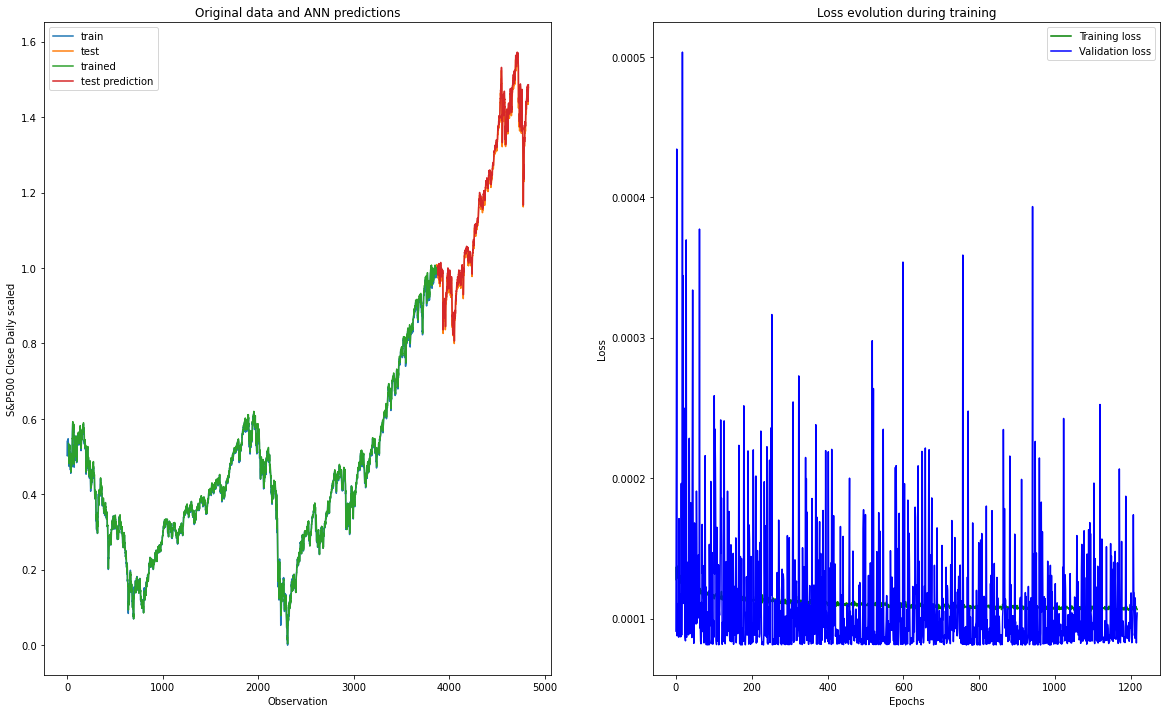

In [ ]:
X_train, y_train = prepare_time_series(
    train_scaled, train_scaled, p["Window"])
X_test, y_test = prepare_time_series(
    test_scaled, test_scaled, p["Window"])
ann_train_loss = ann.evaluate(x=X_train,
    y=y_train,
    batch_size=p["batch_size"])
ann_test_loss = ann.evaluate(x=X_test,
    y=y_test,
    batch_size=p["batch_size"])
y_train_pred = ann.predict(X_train)
y_test_pred = ann.predict(X_test)

print("ANN train: {}".format(ann_train_loss))
print("ANN test: {}".format(ann_test_loss))
print("MSE of a trivial predictor on train data:\t{:0.8f}".
        format(mean_squared_error(y_train[1:], y_train[:-1])))
print("MSE of a trivial predictor on test data:\t{:0.8f}".
        format(mean_squared_error(y_test[1:], y_test[:-1])))
print("MSE of the trained ANN on train data:\t{:0.8f}".
        format(mean_squared_error(y_train, y_train_pred)))
print("MSE of the trained ANN on test data:\t{:0.8f}".
        format(mean_squared_error(y_test, y_test_pred)))

plt.figure(figsize=(20, 12))
plt.subplot(1,2,1)
plt.plot(range(test_split), train_scaled, label="train")
plt.plot(range(test_split, len(df)), test_scaled, label="test")
plt.plot(range(p["Window"], p["Window"] + len(y_train_pred)),
            y_train_pred, label="trained")
plt.plot(range(p["Window"] + test_split, p["Window"] + test_split + len(y_test_pred)),
            y_test_pred, label="test prediction")
plt.title("Original data and ANN predictions")
plt.xlabel("Observation")
plt.ylabel("S&P500 Close Daily scaled")
plt.legend()

skip = 50  # si los primeros valores son muy altos se pueden eliminar
# del gráfico para evitar que afecten la escala automática
# avoid autoscale issues
plt.subplot(122)
plt.plot(history.history["loss"][skip:], "g",
            label="Training loss")
if (p["val_split"] != 0.0):
    plt.plot(history.history["val_loss"][skip:], "b",
                label="Validation loss")
plt.title("Loss evolution during training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


```
# resultados variando el optimizador
best_ann = (149, 18, 71)  # con 10% de mutación
best_ann = (33, 14, 78)  # con 5% de mutación
Test loss
adamax   0.00017806104733608663 low sigma
adam     0.0002559765998739749 medium sigma
nadam    0.0002807788841892034 high sigma
sgd      0.0015213494189083576 smooth
rmsprop  0.002701616147533059 high sigma
adagrad  0.010729542002081871 smooth
ftrl     0.10698116570711136 bad
adadelta 0.4015085995197296 bad

best so far (13, 21, 30, nadam)
```

